# Introduction

This is the main notebook containing all the findings gathered from all previous noteboooks summarized into one. The goal of this notebook is to create an Anime Recommenation System.

Steps include:

1. Environment Setup
2. Preprocessing Data
3. Training CBRS Models
4. Training NCFRS Models
5. Generating Recommendations
6. Deploy Models on Flask

# Preliminary Setup : (Libraries, Data Loading, etc...)

## Libraries Setup

In [2]:
!pip install scikit-surprise
!pip install Flask pyngrok
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
import re
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import os

from nltk.corpus import stopwords
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Concatenate, Dropout
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, accuracy, SVD, KNNBasic
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

In [4]:
# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Data Loading

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Loading the data from drive
ratings_df = pd.read_csv('/content/drive/MyDrive/FYP/Anime_Recommendation_Data/rating_complete.csv')
anime_with_synopsis_df = pd.read_csv('/content/drive/MyDrive/FYP/Anime_Recommendation_Data/anime_with_synopsis.csv')
anime_without_s_df = pd.read_csv('/content/drive/MyDrive/FYP/Anime_Recommendation_Data/anime.csv')

# Fixing spelling error in dataset
anime_with_synopsis_df.rename(columns={'sypnopsis': 'Synopsis'}, inplace=True)
anime_df = pd.merge(anime_without_s_df, anime_with_synopsis_df[['MAL_ID', 'Synopsis']], on='MAL_ID', how='left')

In [45]:
# Untouched df to be used for display purposes
Untampered_anime_df = pd.read_csv('/content/drive/MyDrive/FYP/Anime_Recommendation_Data/anime.csv')
Untampered_anime_df = pd.merge(Untampered_anime_df, anime_with_synopsis_df[['MAL_ID', 'Synopsis']], on='MAL_ID', how='left')

In [46]:
Untampered_anime_df['Synopsis'] = Untampered_anime_df['Synopsis'].fillna('')

In [7]:
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,It is the dark century and the people are suff...


In [8]:
ratings_df.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


# Preprocessing Data

## Removing Missing Data

In this section, we provide a brief overview of the data, including checking for missing values.


In [23]:
# Highlighting important data related to the dataframes
print(f"Number of ratings in the ratings dataframe: {ratings_df.shape[0]}")
print(f"Number of unique users in the ratings dataframe: {ratings_df['user_id'].nunique()}")
print("\n")
print(f"Number of anime in the anime dataframe: {anime_df.shape[0]}")
print(f"Number of unique anime in the ratings dataframe: {ratings_df['anime_id'].nunique()}")
print("\n")

Number of ratings in the ratings dataframe: 57633278
Number of unique users in the ratings dataframe: 310059


Number of anime in the anime dataframe: 17562
Number of unique anime in the ratings dataframe: 16872




In [24]:
# Checking for missing values in the dataframes
print(f"Checking for missing values in the anime dataframe: {anime_df.isnull().sum()}\n")
print(f"Checking for missing values in the ratings dataframe: {ratings_df.isnull().sum()}\n")

Checking for missing values in the anime dataframe: MAL_ID              0
Name                0
Score               0
Genres              0
English name        0
Japanese name       0
Type                0
Episodes            0
Aired               0
Premiered           0
Producers           0
Licensors           0
Studios             0
Source              0
Duration            0
Rating              0
Ranked              0
Popularity          0
Members             0
Favorites           0
Watching            0
Completed           0
On-Hold             0
Dropped             0
Plan to Watch       0
Score-10            0
Score-9             0
Score-8             0
Score-7             0
Score-6             0
Score-5             0
Score-4             0
Score-3             0
Score-2             0
Score-1             0
Synopsis         1356
dtype: int64

Checking for missing values in the ratings dataframe: user_id     0
anime_id    0
rating      0
dtype: int64



In [25]:
# Handle the missing values for synopsis
anime_df['Synopsis'] = anime_df['Synopsis'].fillna('')

In [26]:
# Checking again for missing values to determine there are none.
print(f"Checking for missing values in the anime dataframe: {anime_df.isnull().sum()}\n")
print(f"Checking for missing values in the ratings dataframe: {ratings_df.isnull().sum()}\n")

Checking for missing values in the anime dataframe: MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
Synopsis         0
dtype: int64

Checking for missing values in the ratings dataframe: user_id     0
anime_id    0
rating      0
dtype: int64



We perform exploratory data analysis to understand the distribution and characteristics of the data.


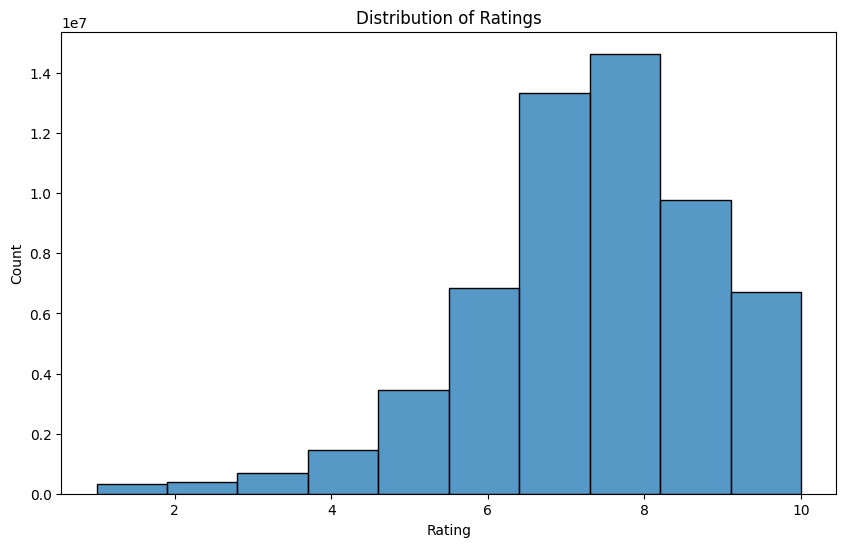

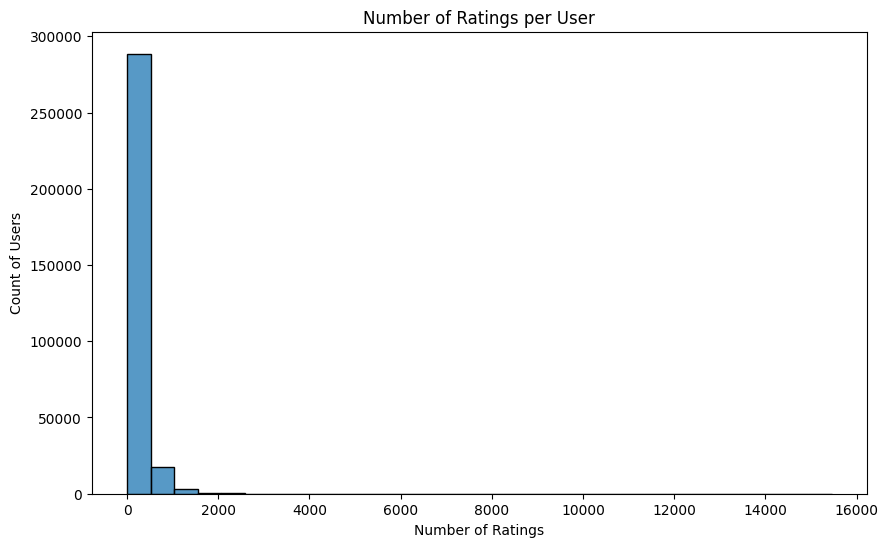

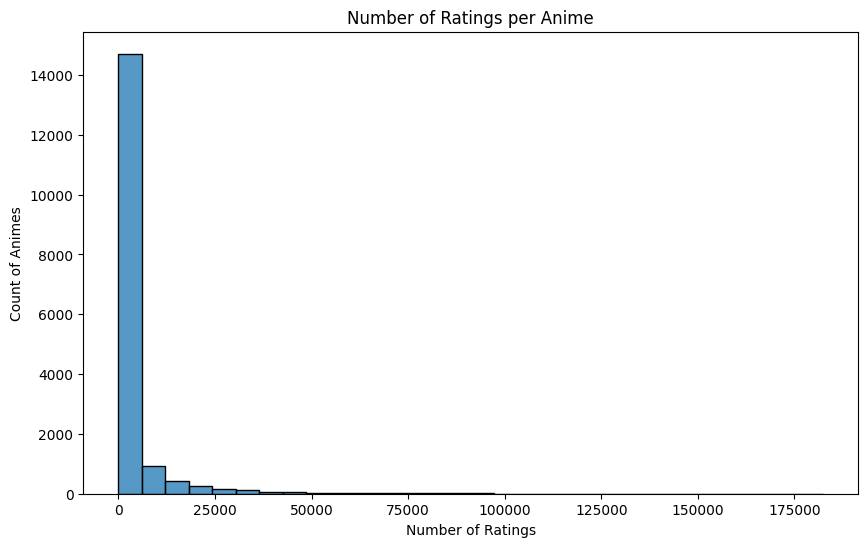

In [13]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print("\n")

# Number of ratings per user
user_ratings_count = ratings_df['user_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=30, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()
print("\n")

# Number of ratings per anime
anime_ratings_count = ratings_df['anime_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(anime_ratings_count, bins=30, kde=False)
plt.title('Number of Ratings per Anime')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Animes')
plt.show()

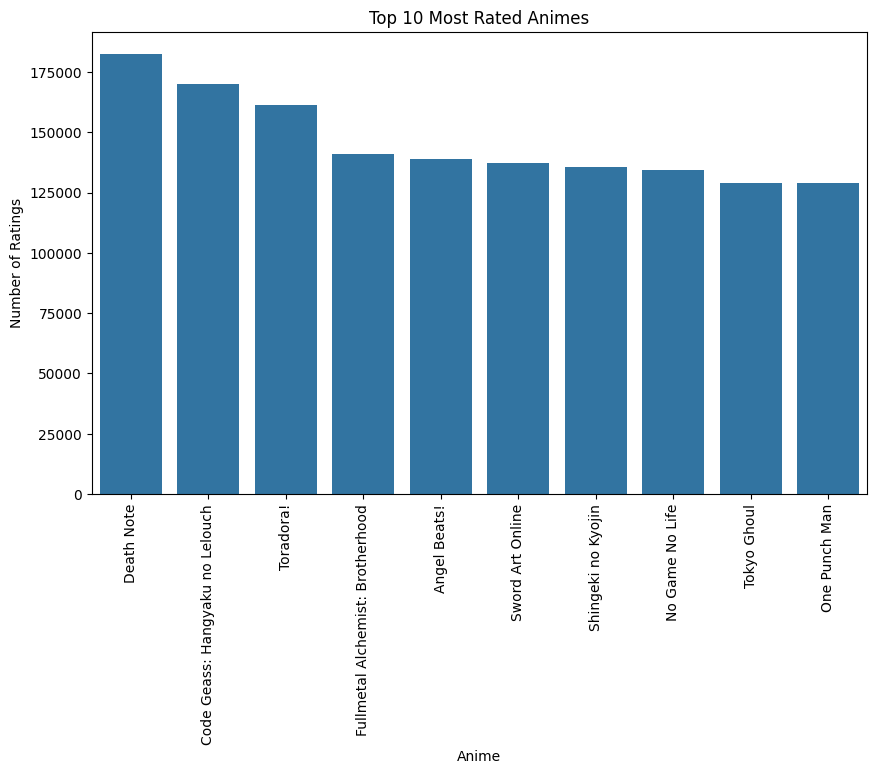

In [14]:
# Top 10 most rated animes
top_anime = anime_ratings_count.head(10)
top_anime_names = anime_df[anime_df['MAL_ID'].isin(top_anime.index)]['Name']
plt.figure(figsize=(10, 6))
sns.barplot(x=top_anime_names, y=top_anime.values)
plt.title('Top 10 Most Rated Animes')
plt.xlabel('Anime')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()

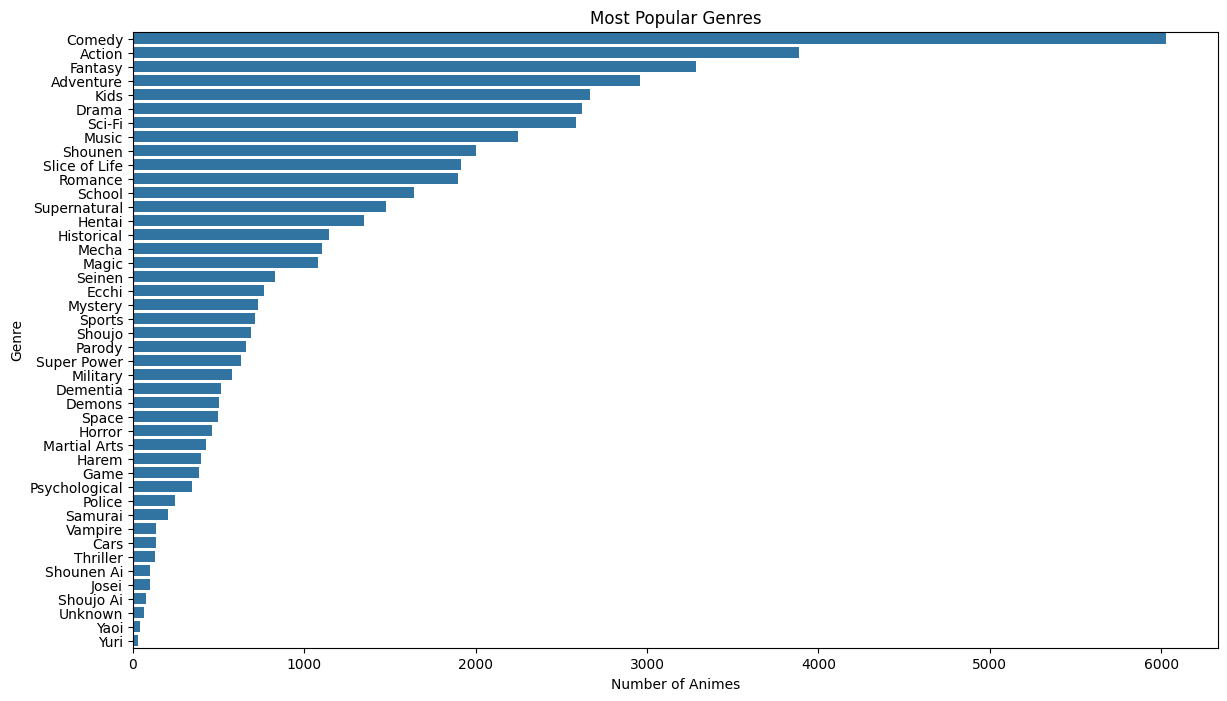

In [15]:
# Split the Genres column into individual genres and explode them into separate rows
anime_df['Genres'] = anime_df['Genres'].str.split(', ')
exploded_genres = anime_df.explode('Genres')

# Count the number of occurrences of each genre
genre_counts = exploded_genres['Genres'].value_counts()

# Plot the most popular genres
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Most Popular Genres')
plt.xlabel('Number of Animes')
plt.ylabel('Genre')
plt.show()

## Cleaning and Removing Unnecessary Data

We clean the data by removing unnecessary text, handling missing values, and filtering out less relevant information. We also encode the categorical features to be used in the models later on.


In [27]:
# Creating functions to clean textual data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function used to process/clean text by removing non-essential text
def preprocess_text_heavy(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    words = text.split()
    # Remove stopwords and rejoin into a string
    return ' '.join([word for word in words if word.lower() not in stop_words])

    return text

# A lighter preprocessing function
def process_text(text):
    return text.lower().split(', ') if pd.notna(text) else []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Dropping unnecessary columns from anime_df
anime_df = anime_df[['MAL_ID', 'Name', 'Genres', 'Score', 'Type', 'Studios', 'Synopsis']]

# Cleaning the synopsis text to tokenize later
anime_df['Synopsis'] = anime_df['Synopsis'].apply(preprocess_text_heavy)

# Lighter preprocessing for the other columns
anime_df['Genres'] = anime_df['Genres'].apply(process_text)
anime_df['Studios'] = anime_df['Studios'].apply(process_text)

# Since there is one type, we only need to lowercase the strings
anime_df['Type'] = anime_df['Type'].apply(lambda x: [x.lower()] if pd.notna(x) else [])

## Encoding categorical data
# One-hot encoding for Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(anime_df['Genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genres.classes_)

# One-hot encoding for Studios
mlb_studios = MultiLabelBinarizer()
studios_encoded = mlb_studios.fit_transform(anime_df['Studios'])
studios_df = pd.DataFrame(studios_encoded, columns=mlb_studios.classes_)

# One-hot encoding for Type
mlb_type = MultiLabelBinarizer()
type_encoded = mlb_type.fit_transform(anime_df['Type'])
type_df = pd.DataFrame(type_encoded, columns=mlb_type.classes_)

# Concatenate the encoded dataframes
anime_df = pd.concat([anime_df, genres_df, studios_df, type_df], axis=1)

# Drop the original categorical columns
anime_df = anime_df.drop(['Genres', 'Studios', 'Type'], axis=1)

# Save cleaned up anime df
# anime_df.to_csv('/content/drive/MyDrive/FYP/Anime_Recommendation_Data/anime_cleaned.csv', index=False)

anime_df_minified = anime_df[['MAL_ID', 'Name', 'Score', 'Synopsis']]

# Replace non-numeric 'Score' values with NaN and then fill NaN with 0
anime_df['Score'] = pd.to_numeric(anime_df['Score'], errors='coerce').fillna(0)

In [29]:
anime_df.head()

,MAL_ID,Name,Score,Synopsis,action,adventure,cars,comedy,dementia,demons,...,zero-g room,zexcs,ziz entertainment (ziz),movie,music,ona,ova,special,tv,unknown
0,1,Cowboy Bebop,8.78,year humanity colonized several planets moons ...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,day another bounty—such life often unlucky cre...,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6,Trigun,8.24,vash stampede man bounty head reason hes merci...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,7,Witch Hunter Robin,7.27,ches individuals special powers like esp telek...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,8,Bouken Ou Beet,6.98,dark century people suffering rule devil vande...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Prepairing the Merged Dataset and Filtering Ratings

Due to the size of the dataset, it was deemed best to filter the ratings before testing models. The de

In [30]:
## Filtering users by number of anime rated
min_ratings_per_user = 650
min_reg_user = 20
max_reg_user = 150

# Identify and filter users who fall within the specified range (20-150) and then store 1,000,000 of their ratings
user_ratings_count = ratings_df['user_id'].value_counts()
reg_users = user_ratings_count[(user_ratings_count >= min_reg_user) & (user_ratings_count <= max_reg_user)].index
req_user_ratings = ratings_df[ratings_df['user_id'].isin(reg_users)]
limited_reg = req_user_ratings.head(1000000)

# Get all users who have rated over 650 anime
active_users = user_ratings_count[user_ratings_count >= min_ratings_per_user].index
filtered_ratings_df = ratings_df[ratings_df['user_id'].isin(active_users)]

## Filtering out anime by number of users (Anime with less than 2,000 members will be filtered out)
min_members_per_anime = 2000
anime_ratings_count = filtered_ratings_df['anime_id'].value_counts()
popular_animes = anime_ratings_count[anime_ratings_count >= min_members_per_anime].index
filtered_ratings_df = filtered_ratings_df[filtered_ratings_df['anime_id'].isin(popular_animes)]

# Combine the ratings datasets
combined_ratings_df = pd.concat([filtered_ratings_df, limited_reg]).drop_duplicates()

## Display the number of ratings and unique users after filtering
num_ratings_after_filtering = filtered_ratings_df.shape[0]
num_unique_users = filtered_ratings_df['user_id'].nunique()
num_unique_animes = filtered_ratings_df['anime_id'].nunique()
reg_unique_users = limited_reg['user_id'].nunique()
reg_unique_anime = limited_reg['anime_id'].nunique()
full_num_ratings_after_filtering = combined_ratings_df.shape[0]
full_num_unique_users = combined_ratings_df['user_id'].nunique()
full_num_unique_animes = combined_ratings_df['anime_id'].nunique()

print(f"Number of seasoned users ratings : {num_ratings_after_filtering}")
print(f"Number of unique seasoned users : {num_unique_users}")
print(f"Number of unique animes rated by seasoned viewers: {num_unique_animes}\n")
print(f"Number of regular anime users: {reg_unique_users}")
print(f"Number of ratings made by regular users: {limited_reg.shape[0]}")
print(f"Number of unique anime rated by regular user:{reg_unique_anime}\n")
print(f"Full list of user ratings:{full_num_ratings_after_filtering}")
print(f"Full list of unique users:{full_num_unique_users}")
print(f"Full list of unique anime:{full_num_unique_animes}")

Number of seasoned users ratings : 8946796
Number of unique seasoned users : 13047
Number of unique animes rated by seasoned viewers: 2143

Number of regular anime users: 13083
Number of ratings made by regular users: 1000000
Number of unique anime rated by regular user:9108

Full list of user ratings:9946796
Full list of unique users:26130
Full list of unique anime:9108


In [ ]:
# large_merged_df = pd.merge(combined_ratings_df, anime_df_minified, left_on='anime_id', right_on='MAL_ID')

# Content-Based Models (TF-IDF and Count Vectorizer)

In this section we build two content-based models using distinct techniques. TF-DF Vectorizer and Count Vectorizer are used to capture the importance of words and calculate the similarity of each anime. The more similar the higher the score.

This section has been previously done using the synopsis solely, but did not yield satisfactory results. Therefore features such as genre, studios, and anime type were encoded and trained alongside the synopsis. This yielded significantly better results.

## Create and Train CBRSs

In [ ]:
# Transform the anime synopses into a TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime_df['Synopsis'])

# Combine TF-IDF matrix with encoded features
encoded_features = anime_df.drop(['MAL_ID', 'Name', 'Synopsis'], axis=1).values
tfidf_combined = np.hstack([tfidf_matrix.toarray(), encoded_features])

# Compute the cosine similarity matrix
tfidf_cosine_sim = cosine_similarity(tfidf_combined, tfidf_combined)

#  Create another feature representation using Count Vectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(anime_df['Synopsis'])

# Combine Count matrix with encoded features
count_combined = np.hstack([count_matrix.toarray(), encoded_features])

# Compute the cosine similarity matrix
count_cosine_sim = cosine_similarity(count_combined, count_combined)

## Load Previously Trained CBRSs

In [31]:
# File paths
tfidf_model_path = '/content/drive/MyDrive/FYP/Models/tfidf_model.pkl'
count_vectorizer_model_path = '/content/drive/MyDrive/FYP/Models/count_vectorizer_model.pkl'
encoded_features_path = '/content/drive/MyDrive/FYP/Models/encoded_features.npy'

# Load the saved models
tfidf = joblib.load(tfidf_model_path)
count = joblib.load(count_vectorizer_model_path)
encoded_features = np.load(encoded_features_path)

## Compute the similarity matrices again
# TF-IDF Model
tfidf_matrix = tfidf.transform(anime_df['Synopsis'])
tfidf_combined = np.hstack([tfidf_matrix.toarray(), encoded_features])
tfidf_cosine_sim = cosine_similarity(tfidf_combined, tfidf_combined)
# Count Vectorizer
count_matrix = count.transform(anime_df['Synopsis'])
count_combined = np.hstack([count_matrix.toarray(), encoded_features])
count_cosine_sim = cosine_similarity(count_combined, count_combined)

## Generating Recommendations and Calculating Coverage

In [32]:
# Function to generate recommendations using content-based models
def get_content_recommendations_2(anime_ids, cosine_sim, df, n=10):

    # Get the indices of the anime based on the MAL_ID
    indices = [df.index[df['MAL_ID'] == anime_id].tolist()[0] for anime_id in anime_ids]

    # Get the similarity scores of the anime based on cosine similarity
    sim_scores = np.mean([list(enumerate(cosine_sim[idx])) for idx in indices], axis=0)

    # Sort the sim scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filter out input anime and select top n
    sim_scores = [score for score in sim_scores if score[0] not in indices][:n]

    # Get the indices of the top n anime
    anime_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    # Return the top n anime alongside their sim scores
    return df.iloc[anime_indices][['MAL_ID', 'Name']], scores

# Example anime ids [Cowboy Bebop, Naruto, Bleach]
anime_ids_example = [1, 20, 269]

# Generate recommendations and sim scores using TF-IDF
tfidf_recommendations, tfidf_scores = get_content_recommendations_2(anime_ids_example, tfidf_cosine_sim, anime_df)

# Generate recommendations and sim scores using Count
count_recommendations, count_scores = get_content_recommendations_2(anime_ids_example, count_cosine_sim, anime_df)

print("TF-IDF Recommendations:")
print(tfidf_recommendations)
print("TF-IDF Similarity Scores:", tfidf_scores)

print("Count Vectorizer Recommendations:")
print(count_recommendations)
print("Count Vectorizer Similarity Scores:", count_scores)

TF-IDF Recommendations:
       MAL_ID                                               Name
1574     1735                                 Naruto: Shippuuden
214       238                                     Rekka no Honoo
132       154                                        Shaman King
10573   30503                                   Noragami Aragoto
4440     6067                                     Moeru! Oniisan
11179   31933  JoJo no Kimyou na Bouken Part 4: Diamond wa Ku...
8292    20507                                           Noragami
450       479                                    Ueki no Housoku
11         21                                          One Piece
1460     1604                             Katekyo Hitman Reborn!
TF-IDF Similarity Scores: [0.9672206496817369, 0.9549828940476286, 0.9546980757538822, 0.9541050974156637, 0.9539987848977881, 0.9533563544150869, 0.9532086084061646, 0.9520467915271377, 0.9518243134225538, 0.9516177706742704]
Count Vectorizer Recommendations:


In [ ]:
## Save the TF-IDF model
#joblib.dump(tfidf, tfidf_model_path)

## Save the Count Vectorizer model
#count_vectorizer_model_path = '/content/drive/MyDrive/FYP/Models/count_vectorizer_model.pkl'
#joblib.dump(count, count_vectorizer_model_path)

## Save the combined encoded features for later use
#encoded_features_path = '/content/drive/MyDrive/FYP/Models/encoded_features.npy'
#np.save(encoded_features_path, encoded_features)

In [ ]:
def get_anime_recommendations_tfidf(title, n=10):
    # Get the MAL_ID of the anime based on the title
    anime_id = anime_df[anime_df['Name'] == title]['MAL_ID'].values[0]
    # Generate recommendations and sim scores using TF-IDF
    recommendations, _ = get_content_recommendations_2([anime_id], tfidf_cosine_sim, anime_df, n)
    # Return a lost of the recommended anime IDs
    return recommendations['MAL_ID'].tolist()

def get_anime_recommendations_count(title, n=10):
    # Get the MAL_ID of the anime based on the title
    anime_id = anime_df[anime_df['Name'] == title]['MAL_ID'].values[0]
    # Generate recommendations and sim scores using Count
    recommendations, _ = get_content_recommendations_2([anime_id], count_cosine_sim, anime_df, n)
    # Return a lost of the recommended anime IDs
    return recommendations['MAL_ID'].tolist()

In [ ]:
# Coverage: Fraction of items that can be recommended
def calculate_coverage(recommendation_function, n=10):
    unique_recommendations = set()

    # Iterate over each anime in the anime dataframe
    for title in anime_df['Name']:
        try:
            # Generate recommendations for the anime and update set of unique anime
            recommendations = recommendation_function(title, n=n)
            unique_recommendations.update(recommendations)
        except IndexError:
            continue  # Skip titles that are not found

    # Calculate coverage as the fraction of unique recommendations over the total number of anime
    coverage = len(unique_recommendations) / len(anime_df)
    return coverage

# Coverage for Count Vectorizer
coverage_count = calculate_coverage(get_anime_recommendations_count)
print(f"Coverage using Count Vectorizer: {coverage_count:.2f}")

# Coverage for TF-IDF
coverage_tfidf = calculate_coverage(get_anime_recommendations_tfidf)
print(f"Coverage using TF-IDF: {coverage_tfidf:.2f}")

Coverage using Count Vectorizer: 0.65
Coverage using TF-IDF: 0.94


While I subjectively knew the recommendations generated by count vectorizer were of a lower quality this full test clearly sements the difference between the two models. Ultimately, TF-IDF is the superior model.

# Neural Collaborative Filtering (NCFRS)

This section aims to build and evaluate the neural collabrative filtering model. There are two distinct models, one was built using the filtered ratings dataset and another was built using the full dataset. The reason for the discrepancy was due to how taxing the full dataset was when training while using the free version. Later, the paid version allowed processing the full ratings dataset.

However, integrating the synopsis and encoded features with the full ratings model proved challenging, especially when attempting grid search with additional features. Future iterations will aim to utilize these features more effectively.

## NCFRS Model Blueprint

In [33]:
# Define the model
embedding_dim = 50

user_input = Input(shape=(1,), name='user_input')
anime_input = Input(shape=(1,), name='anime_input')

user_embedding = Embedding(input_dim=combined_ratings_df['user_id'].nunique(), output_dim=embedding_dim, name='user_embedding')(user_input)
anime_embedding = Embedding(input_dim=combined_ratings_df['anime_id'].nunique(), output_dim=embedding_dim, name='anime_embedding')(anime_input)

user_vec = Flatten()(user_embedding)
anime_vec = Flatten()(anime_embedding)

concat = Concatenate()([user_vec, anime_vec])
dense_1 = Dense(256, activation='relu')(concat)
dropout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(dense_2)
output = Dense(1, activation='linear')(dropout_2)

model = Model(inputs=[user_input, anime_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 50)          │      1,306,500 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_embedding           │ (None, 1, 50)          │        455,400 │ anime_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ anime_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         25,856 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,820,781 (6.95 MB)

 Trainable params: 1,820,781 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

## NCFRS Filtered Model

### Prepairing the data for the filtered NCFRS model

In [34]:
user_ids = combined_ratings_df['user_id'].unique()
anime_ids = combined_ratings_df['anime_id'].unique()

print(f'{user_ids.shape [0]} unique users')
print(f'{anime_ids.shape [0]} unique animes')

# Create mappings for user and anime IDs
user_id_map = {id: index for index, id in enumerate(user_ids)}
anime_id_map = {id: index for index, id in enumerate(anime_ids)}

combined_ratings_df['user_id'] = combined_ratings_df['user_id'].map(user_id_map)
combined_ratings_df['anime_id'] = combined_ratings_df['anime_id'].map(anime_id_map)

# Displaying the first few rows to confirm the structure
print(combined_ratings_df.head())
print(combined_ratings_df.columns)
print(combined_ratings_df.info())

26130 unique users
9108 unique animes
      user_id  anime_id  rating
1683        0         0       7
1684        0         1      10
1685        0         2       2
1686        0         3       6
1687        0         4       6
Index(['user_id', 'anime_id', 'rating'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 9946796 entries, 1683 to 5340837
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 303.6 MB
None


In [ ]:
# Split data into training and test sets
train_df_small, test_df_small = sklearn_train_test_split(combined_ratings_df, test_size=0.15, random_state=20)

## Prepare input data
# Filtered NCFRS training data
train_user_ids_small = train_df_small['user_id'].values
train_anime_ids_small = train_df_small['anime_id'].values
train_ratings_small = train_df_small['rating'].values

# Filtered NCFRS test data
test_user_ids_small = test_df_small['user_id'].values
test_anime_ids_small = test_df_small['anime_id'].values
test_ratings_small = test_df_small['rating'].values

### Training and saving the filtered NCFRS model

In [ ]:
# Train the filtered NCFRS model
history = model.fit([train_user_ids_small, train_anime_ids_small], train_ratings_small, epochs=6, batch_size=128, validation_data=([test_user_ids_small, test_anime_ids_small], test_ratings_small))

# Evaluate the filtered NCFRS model
loss, mae = model.evaluate([test_user_ids_small, test_anime_ids_small], test_ratings_small)
print(f"Test MAE: {mae}")

In [ ]:
# Save filtered NCFRS model
#model.save('/content/drive/MyDrive/FYP/Models/ncfrs_model_combrat_650_2000.keras')

## NCFRS Full Model

### Prepairing the data for the full NCFRS model

In [35]:
user_ids_full = ratings_df['user_id'].unique()
anime_ids_full = ratings_df['anime_id'].unique()

print(f'{user_ids_full.shape[0]} unique users')
print(f'{anime_ids_full.shape[0]} unique animes')

# Create mappings for user and anime IDs
user_id_map_full = {id: index for index, id in enumerate(user_ids_full)}
anime_id_map_full = {id: index for index, id in enumerate(anime_ids_full)}

# Apply the mappings to the existing columns
ratings_df['user_id'] = ratings_df['user_id'].map(user_id_map_full)
ratings_df['anime_id'] = ratings_df['anime_id'].map(anime_id_map_full)

310059 unique users
16872 unique animes


In [ ]:
# Split data into training and test sets
train_df, test_df = sklearn_train_test_split(ratings_df, test_size=0.15, random_state=20)

## Prepare input data
# Full NCFRS train data
train_user_ids = train_df['user_id'].values
train_anime_ids = train_df['anime_id'].values
train_ratings = train_df['rating'].values

# Full NCFRS test data
test_user_ids = test_df['user_id'].values
test_anime_ids = test_df['anime_id'].values
test_ratings = test_df['rating'].values

# Check the unique counts for embedding layers
num_users = ratings_df['user_id'].nunique()
num_animes = ratings_df['anime_id'].nunique()

print(f'{num_users} unique users after mapping')
print(f'{num_animes} unique animes after mapping')

### Training and saving the full NCFRS model

In [ ]:
# Train the full NCFRS model
history = model.fit([train_user_ids, train_anime_ids], train_ratings, epochs=6, batch_size=128, validation_data=([test_user_ids, test_anime_ids], test_ratings))

# Evaluate the full NCFRS model
loss, mae = model.evaluate([test_user_ids, test_anime_ids], test_ratings)
print(f"Test MAE: {mae}")

In [ ]:
# Save filtered full model
#model.save('/content/drive/MyDrive/FYP/Models/full_model_combrat_650_2000.keras')

## Load The Previously Saved Models to Generate

In [36]:
# Load NCFRS models
model_ncfrs_650_2000 = load_model('/content/drive/MyDrive/FYP/Models/ncfrs_model_combrat_650_2000.keras')
model_full = load_model('/content/drive/MyDrive/FYP/Models/ncfrs_full.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [147]:
model_full = load_model('/content/drive/MyDrive/FYP/Models/ncfrs_full.keras')

## NCFRS Recommendation Generation

In [54]:
# Generate rcommendations for NCFRS models. Input = liked anime, Output = recommendations, scores
def get_recommendations_for_new_user_3(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, n=10):
    # Convert the anime IDs to the mapped IDs used in the model
    mapped_anime_ids = [anime_id_map[anime_id] for anime_id in user_liked_anime_ids]

    # Calculate average embedding for liked animes
    liked_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0][mapped_anime_ids]
    avg_embedding = np.mean(liked_anime_embeddings, axis=0)

    # Get all anime embeddings
    all_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0]

    # Compute similarity between the average embedding and all anime embeddings
    similarities = np.dot(all_anime_embeddings, avg_embedding)

    # Create a DataFrame to store anime IDs and their similarity scores
    similarity_df = pd.DataFrame({'anime_id': anime_ids, 'similarity': similarities})

    # Filter out the liked animes from the recommendations
    similarity_df = similarity_df[~similarity_df['anime_id'].isin(user_liked_anime_ids)]

    # Sort by similarity score
    top_n_similarities = similarity_df.nlargest(n, 'similarity')

    # Get the top N animes with highest similarity
    top_n_anime_ids = top_n_similarities['anime_id'].values
    top_n_similarities = top_n_similarities['similarity'].values

    # Return the anime details along with similarity scores
    return anime_df[anime_df['MAL_ID'].isin(top_n_anime_ids)], top_n_similarities

In [55]:
# Generte and predict filtered NCFRS model recommendations
recommendations, scores = get_recommendations_for_new_user_3(anime_ids_example, model_ncfrs_650_2000, Untampered_anime_df, anime_id_map, anime_ids, n=15)
for anime, score in zip(recommendations.itertuples(), scores):
    print(f"Anime: {anime.Name}, Similarity Score: {score}")

Anime: Monster, Similarity Score: 11.979045867919922
Anime: Kenpuu Denki Berserk, Similarity Score: 11.617232322692871
Anime: Slam Dunk, Similarity Score: 11.45383358001709
Anime: Hajime no Ippo, Similarity Score: 11.44079303741455
Anime: Yuu☆Yuu☆Hakusho, Similarity Score: 10.683730125427246
Anime: Perfect Blue, Similarity Score: 10.216523170471191
Anime: Mushishi, Similarity Score: 9.946259498596191
Anime: Ginga Eiyuu Densetsu, Similarity Score: 9.497392654418945
Anime: Death Note, Similarity Score: 9.417304992675781
Anime: Ashita no Joe 2, Similarity Score: 9.409646034240723
Anime: Gyakkyou Burai Kaiji: Ultimate Survivor, Similarity Score: 9.13046932220459
Anime: Fullmetal Alchemist: Brotherhood, Similarity Score: 9.082025527954102
Anime: Hunter x Hunter (2011), Similarity Score: 9.046972274780273
Anime: Mushishi Zoku Shou 2nd Season, Similarity Score: 9.010746955871582
Anime: Vinland Saga, Similarity Score: 8.986330032348633


In [57]:
# Generte, predict, and display full NCFRS model recommendations
recommendations_f, scores_f = get_recommendations_for_new_user_3(anime_ids_example, model_full, Untampered_anime_df, anime_id_map_full, anime_ids_full, n=15)
for anime, score in zip(recommendations_f.itertuples(), scores_f):
    print(f"Anime: {anime.Name}, Similarity Score: {score},  Genres: {row.Genres}, Synopsis: {row.Synopsis}")

Anime: Monster, Similarity Score: 6.972129821777344,  Genres: Action, Adventure, Comedy, Supernatural, Shounen, Synopsis: Yato and Yukine have finally mended their relationship as god and Regalia, and everyone has returned to their daily life. Yato remains a minor and unknown deity who continues taking odd jobs for five yen apiece in the hopes of one day having millions of worshippers and his own grand shrine. Hiyori Iki has yet to have her loose soul fixed by Yato, but she enjoys life and prepares to attend high school nonetheless. Taking place immediately after the first season, Noragami Aragoto delves into the complicated past between Yato and the god of war Bishamon. The female god holds a mysterious grudge against Yato, which often results in violent clashes between them. It doesn't help that Bishamon's most trusted and beloved Regalia, Kazuma, appears to be indebted to Yato. When lives are on the line, unraveling these mysteries and others may be the only way to correct past mist

The full model generally provides better recomendation compared to the filtered model which is why it will be utilized when deployed in the website as well as in the hybrid model

# Hybrid Model (TF-IDF - Full NCFRS)

This section demonstrates how to build a hybrid recommendation system that combines the best recommendations of both TF-IDF and Neural Collaborative Filtering (NCFRS) models. Its a more simplistic hybrid model as attempts at more complicated iterations proved too difficult.

Future projects include adding a method for user to give feedback to the model in the form of postive and negative reinforcement.

## Pre-Normalization

In [40]:
def get_recommendations_ncfrs(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, n=10):
    # Convert the liked anime IDs to their corresponding mapped IDs used in the model
    mapped_anime_ids = [anime_id_map[anime_id] for anime_id in user_liked_anime_ids]

    # Calculate the average embedding for liked animes
    liked_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0][mapped_anime_ids]
    avg_embedding = np.mean(liked_anime_embeddings, axis=0)

    # Get all anime embeddings
    all_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0]

    # Compute similarity between the average embedding and all anime embeddings
    similarities = np.dot(all_anime_embeddings, avg_embedding)

    # Get the top N most similar anime indices
    top_n_anime_indices = similarities.argsort()[-n:][::-1]

    # Filter out the liked animes from the recommendations
    top_n_anime_indices = [index for index in top_n_anime_indices if index not in mapped_anime_ids][:n]

    # Get the corresponding anime IDs for the top N recommendations
    top_n_anime_ids = [anime_ids[index] for index in top_n_anime_indices]

    return anime_df[anime_df['MAL_ID'].isin(top_n_anime_ids)], similarities[top_n_anime_indices][:len(top_n_anime_ids)]

def get_recommendations_tfidf(user_liked_anime_ids, anime_df, tfidf_cosine_sim, n=10):
    # Create a series with anime indices mapped by their MAL_IDs
    indices = pd.Series(anime_df.index, index=anime_df['MAL_ID']).drop_duplicates()

    # Calculate the average similarity scores for liked animes
    sim_scores = tfidf_cosine_sim[indices[user_liked_anime_ids]].mean(axis=0)

    # Get the top N most similar anime indices
    top_n_anime_indices = sim_scores.argsort()[-n:][::-1]

    # Filter out the liked animes from the recommendations
    top_n_anime_indices = [index for index in top_n_anime_indices if index not in indices[user_liked_anime_ids]][:n]

    return anime_df.iloc[top_n_anime_indices], sim_scores[top_n_anime_indices]

In [49]:
def hybrid_recommendations(user_liked_anime_ids, model, anime_df, Untampered_anime_df, anime_id_map, anime_ids, tfidf_cosine_sim, n=10):
    # Get recommendations from the NCFRS model
    recs_ncfrs, scores_ncfrs = get_recommendations_ncfrs(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, n=10)

    # Get recommendations from the TF-IDF model
    recs_tfidf, scores_tfidf = get_recommendations_tfidf(user_liked_anime_ids, anime_df, tfidf_cosine_sim, n=10)

    # Store the MAL_IDs of recommendations with scores and which model generated them(source)
    recs_list = []
    for i in range(10):
        if i < len(recs_ncfrs):
            recs_list.append((recs_ncfrs.iloc[i]['MAL_ID'], scores_ncfrs[i], 'NCFRS'))
        if i < len(recs_tfidf):
            recs_list.append((recs_tfidf.iloc[i]['MAL_ID'], scores_tfidf[i], 'TFIDF'))

    # Drop duplicate MAL_IDs while keeping the highest score
    recs_df = pd.DataFrame(recs_list, columns=['MAL_ID', 'Similarity_Score', 'Source'])
    recs_df = recs_df.sort_values(by='Similarity_Score', ascending=False).drop_duplicates(subset='MAL_ID')

    # Filter out the liked anime
    recs_df = recs_df[~recs_df['MAL_ID'].isin(user_liked_anime_ids)]

    # Select top recommendations from each source
    top_recs_ncfrs = recs_df[recs_df['Source'] == 'NCFRS'].head(6)
    top_recs_tfidf = recs_df[recs_df['Source'] == 'TFIDF'].head(4)

    # Combine the top recommendations
    final_recs_df = pd.concat([top_recs_ncfrs, top_recs_tfidf])

    # Get the anime details
    #final_recs = anime_df[anime_df['MAL_ID'].isin(final_recs_df['MAL_ID'])]
    final_recs = Untampered_anime_df[Untampered_anime_df['MAL_ID'].isin(final_recs_df['MAL_ID'])]

    # Merge with the final_recs_df to include scores and sources
    final_recs = final_recs.merge(final_recs_df, on='MAL_ID')

    #for row in final_recs.itertuples():
    #    print(f"Anime: {row.Name}, Anime Score: {row.Score}, Similarity Score: {row.Similarity_Score}, Source: {row.Source}")

    return final_recs

In [53]:
# Generate hybrid recommendations
hyb_rec = hybrid_recommendations(anime_ids_example, model_full, anime_df, Untampered_anime_df, anime_id_map_full, anime_ids_full, tfidf_cosine_sim, n=10)
# Print the final recommendations with similarity scores and sources
for row in hyb_rec.itertuples():
    print(f"Anime: {row.Name}, Anime Score: {row.Score}, Similarity Score: {row.Similarity_Score},  Genres: {row.Genres}, Synopsis: {row.Synopsis}")
#

Anime: Monster, Anime Score: 8.76, Similarity Score: 6.972129821777344,  Genres: Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller, Synopsis: Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—lo

## Post-Normalization

In [58]:
from sklearn.preprocessing import MinMaxScaler

def normalize_scores(scores):
    scaler = MinMaxScaler()
    scores = np.array(scores).reshape(-1, 1)
    normalized_scores = scaler.fit_transform(scores)
    return normalized_scores.flatten()

In [120]:
def get_recommendations_ncfrs(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, n=10):
    mapped_anime_ids = [anime_id_map[anime_id] for anime_id in user_liked_anime_ids]
    liked_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0][mapped_anime_ids]
    avg_embedding = np.mean(liked_anime_embeddings, axis=0)
    all_anime_embeddings = model.get_layer('anime_embedding').get_weights()[0]
    similarities = np.dot(all_anime_embeddings, avg_embedding)
    similarity_df = pd.DataFrame({'anime_id': anime_ids, 'similarity': similarities})
    similarity_df = similarity_df[~similarity_df['anime_id'].isin(user_liked_anime_ids)]
    top_n_similarities = similarity_df.nlargest(n, 'similarity')
    top_n_anime_ids = top_n_similarities['anime_id'].values
    top_n_similarities = normalize_scores(top_n_similarities['similarity'].values)
    recommendations = anime_df[anime_df['MAL_ID'].isin(top_n_anime_ids)].copy()
    recommendations['Similarity_Score'] = top_n_similarities
    recommendations['Source'] = 'NCFRS'
    return recommendations[['MAL_ID', 'Name', 'Similarity_Score', 'Source', 'Score','Genres', 'Synopsis']].to_dict(orient='records')

def get_recommendations_content_based(user_liked_anime_ids, anime_df, tfidf_cosine_sim, n=10):
    indices = pd.Series(anime_df.index, index=anime_df['MAL_ID']).drop_duplicates()
    sim_scores = tfidf_cosine_sim[indices[user_liked_anime_ids]].mean(axis=0)

    # Sort the sim scores in descending order
    sorted_sim_scores = sorted(enumerate(sim_scores), key=lambda x: x[1], reverse=True)

    # Filter out input anime and select top n
    filtered_sim_scores = [(idx, score) for idx, score in sorted_sim_scores if anime_df.iloc[idx]['MAL_ID'] not in user_liked_anime_ids]

    top_n_sim_scores = filtered_sim_scores[:n]
    top_n_anime_indices = [idx for idx, _ in top_n_sim_scores]
    top_n_similarities = [score for _, score in top_n_sim_scores]

    # Normalize the similarity scores
    top_n_similarities = normalize_scores(top_n_similarities)

    recommendations = anime_df.iloc[top_n_anime_indices].copy()
    recommendations['Similarity_Score'] = top_n_similarities
    recommendations['Source'] = 'TFIDF'
    return recommendations[['MAL_ID', 'Name', 'Similarity_Score', 'Source', 'Score','Genres', 'Synopsis']].to_dict(orient='records')

In [121]:
def hybrid_recommendations(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, tfidf_cosine_sim, count_cosine_sim, n=10):
    recs_ncfrs = get_recommendations_ncfrs(user_liked_anime_ids, model, anime_df, anime_id_map, anime_ids, n=n)
    recs_tfidf = get_recommendations_content_based(user_liked_anime_ids, anime_df, tfidf_cosine_sim, n=n)
    #recs_count = get_recommendations_content_based(user_liked_anime_ids, anime_df, count_cosine_sim, n=n)

    combined_recs = recs_ncfrs + recs_tfidf
    unique_recs = {v['MAL_ID']: v for v in combined_recs}.values()

    sorted_unique_recs = sorted(unique_recs, key=lambda x: x['Similarity_Score'], reverse=True)[:n]

    return sorted_unique_recs

In [68]:
anime_ids_example = [1, 20, 269]

In [94]:
# Generate hybrid recommendations
hyb_rec = hybrid_recommendations(anime_ids_example, model_full, Untampered_anime_df, anime_id_map_full, anime_ids_full, tfidf_cosine_sim, count_cosine_sim, n=10)
# Print the final recommendations with similarity scores and sources
print(hyb_rec)

[{'MAL_ID': 19, 'Name': 'Monster', 'Similarity_Score': 1.0, 'Source': 'NCFRS', 'Score': '8.76', 'Genres': 'Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller', 'Synopsis': "Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious 

# Flask Web App

In [157]:
from flask import Flask, render_template, request, redirect, url_for, make_response
from pyngrok import ngrok

ngrok.set_auth_token("2ih00gBM5g5arG3gGlWGBGlZ3UL_6txwfZRz46vz6WNFTJDvN")

app = Flask(__name__, template_folder='/content/drive/MyDrive/FYP/Web/dependancy/templates', static_folder='/content/drive/MyDrive/FYP/Web/dependancy/static')

In [158]:
TEMPLATE = """<header>
    <h3>{}</h3>
	<p>Genres: {} | MyAnimeList.net Rating: {} | Similarity Score: {}</p>
</header>
<p>{}</p>
"""

class Anime:
    def __init__(self, model_dict: dict):
        self.name = str(model_dict.pop('Name', 'Name Unknown')).strip().title()
        self.score = str(model_dict.pop('Similarity_Score', 'Unknown')).strip()
        self.rating = str(model_dict.pop('Score', 'Unknown')).strip()
        self.synopsis = str(model_dict.pop('Synopsis', 'Synopsis Unknown')).strip()
        self.genres = str(model_dict.pop('Genres', 'Unknown')).strip()

        if self.name == '': self.name = 'Name Unknown'
        if self.score == '': self.score = 'Unknown'
        if self.rating == '': self.rating = 'Unknown'
        if self.synopsis == '': self.synopsis = 'Synopsis Unknown'
        if self.genres == '': self.genres = 'Unknown'

    def to_str(self):
        return TEMPLATE.format(self.name, self.genres, self.rating, self.score, self.synopsis)

    @staticmethod
    def get_list(model_output):
        anime_list = []
        for model_dict in model_output:
            anime_list.append(Anime(model_dict))
        return anime_list

def display_results(model_output):
    output = ""

    for anime in Anime.get_list(model_output):
        output += anime.to_str()

    return output


In [159]:

@app.route('/')
def index():
    age_verified = request.cookies.get('age_verified')
    if age_verified is None:
        return redirect(url_for('verify_age'))
    if age_verified != 'true': # only people who set cookie to true (above 18) can use site
        return render_template('ineligible.html'), 200
    return render_template('index.html'), 200

@app.route('/verify_age', methods=['GET', 'POST'])
def verify_age():
    age_verified = request.cookies.get('age_verified')
    if age_verified is not None:
        return render_template('error.html', error_message='You already verified your age.'), 400
    method = request.method
    if method == 'GET':
        return render_template("popup.html")
    elif method == 'POST':
        above_eighteen = request.form.get('above_eighteen')
        if above_eighteen is None:
            return render_template('error.html', error_message='Error processing your request, try again later.'), 400
        response = make_response(redirect(url_for('index')))
        response.set_cookie(
            'age_verified',
            ('true' if above_eighteen == 'yes' else 'false'),
            max_age=60*60*24*365,
            samesite='Strict',
            httponly=True
        )
        return response
    return render_template('error.html', error_message='Error processing your request, try again later.'), 400

@app.route('/results', methods=['POST'])
def results():

    model = request.form.get('model-choice')
    animes = []
    for i in range(1,6):
        anime_name = request.form.get(f'anime-{i}')
        if anime_name is not None and anime_name != '':
          #animes.append(int(anime_name))
            anime_id = Untampered_anime_df[Untampered_anime_df['Name'] == anime_name]['MAL_ID'].iloc[0]
            #print(anime_id, type(anime_id))
            animes.append(anime_id)
        #if anime is not None: animes.append(anime)

    if model is None or len(animes) == 0:
        return render_template('error.html', error_message='Error processing your request, try again later.'), 400

    if model == 'A':
        model_output = get_recommendations_content_based(animes, Untampered_anime_df, tfidf_cosine_sim, n=10)
    elif model == 'B':
        model_output = get_recommendations_ncfrs(animes, model_full, Untampered_anime_df, anime_id_map_full, anime_ids_full, n=10)
    elif model == 'C':
        model_output = hybrid_recommendations(animes, model_full, Untampered_anime_df, anime_id_map_full, anime_ids_full, tfidf_cosine_sim, count_cosine_sim, n=10)
    else:
        return render_template('error.html', error_message='Invalid model choice.'), 400

    return render_template('results.html', model=f'Model {model}', results=display_results(model_output))


if __name__ == '__main__':
    url = ngrok.connect(5000)
    print(f" * ngrok tunnel \"{url}\" -> \"http://127.0.0.1:5000\"")
    app.run(port=5000)


 * ngrok tunnel "NgrokTunnel: "https://c3e7-34-135-48-97.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:39] "GET / HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /verify_age HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/js/jquery.scrollex.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/js/util.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/js/jquery.scrolly.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/js/jquery.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/css/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Jul/2024 22:27:40] "GET /static/assets/js/browser.min.js HTTP/1.1" 200 -
INFO:w